# Water Resource Management Model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demdp01.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

Public authority must decide how much water to release from a reservoir so as to maximize benefits derived from agricultural and recreational uses.


- States
    -     s       reservoiur level at beginning of summer
- Actions
    -     x       quantity of water released for irrigation
- Parameters
    - a0,a1     -- producer benefit function parameters
    - b0,b1     -- recreational user benefit function parameters
    - $\mu$     -- mean rainfall
    - $\sigma$     -- rainfall volatility
    - $\delta$     -- discount factor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, DPmodel, DPoptions, qnwlogn, demo
import seaborn as sns
import pandas as pd

### Model parameters

In [2]:
a0, a1, b0, b1 = 1, -2, 2, -3 
μ, σ, δ = 1.0, 0.2, 0.9

### Steady-state

The deterministic steady-state values for this model are

In [3]:
xstar = 1.0  # action
sstar = 1.0 + (a0*(1-δ)/b0)**(1/b1)  # stock

### State space
The state variable is s="Reservoir Level", which we restrict to $s\in[2, 8]$. 

Here, we represent it with a Chebyshev basis, with $n=15$ nodes.

In [4]:
n, smin, smax = 15, 2, 8
basis = BasisChebyshev(n, smin, smax, labels=['Reservoir'])

### Continuous state shock distribution

In [5]:
m = 3  #number of rainfall shocks
e, w = qnwlogn(m, np.log(μ)-σ**2/2,σ**2) # rainfall shocks and proabilities

### Action space
The choice variable x="Irrigation" must be nonnegative.

In [6]:
def bounds(s, i=None, j=None):
    return np.zeros_like(s), 1.0*s

### Reward function
The reward function is 

In [7]:
def reward(s, x, i=None, j=None):
    sx = s-x
    u = (a0/(1+a1))*x**(1+a1) + (b0/(1+b1))*sx**(1+b1)
    ux = a0*x**a1 - b0*sx**b1                                 
    uxx = a0*a1*x**(a1-1) + b0*b1*sx**(b1-1)  
    return u, ux, uxx

### State transition function
Next period, reservoir level wealth will be equal to current level minus irrigation plus random rainfall:

In [8]:
def transition(s, x, i=None, j=None, in_=None, e=None):
    g = s - x + e
    gx = -np.ones_like(s)
    gxx = np.zeros_like(s)
    return g, gx, gxx

### Model structure
The value of wealth $s$ satisfies the Bellman equation
\begin{equation*}
V(s) = \max_x\left\{\left(\frac{a_0}{1+a_1}\right)x^{1+a1} + \left(\frac{b_0}{1+b_1}\right)(s-x)^{1+b1}+ \delta V(s-x+e)  \right\}
\end{equation*}

To solve and simulate this model,use the CompEcon class `DPmodel`

In [9]:
water_model = DPmodel(basis, reward, transition, bounds,e=e,w=w,
                       x=['Irrigation'],
                       discount=δ )

## Solving the model

### Compute Linear-Quadratic Approximation at Collocation Nodes

The `DPmodel.lqapprox` solves the linear-quadratic approximation, in this case arround the steady-state. It returns a LQmodel which works similar to the DPmodel object. We compute the solution at the basis nodes to use it as initial guess for the Newton's methods.

In [10]:
water_lq = water_model.lqapprox(sstar,xstar).solution(basis.nodes)


Solving the growth model by collocation. We take the values for the Value and Policy functions at the basis nodes obtained from the linear-quadratic approximation as initial guess values for the Newton's method.

In [11]:
S = water_model.solve(v=water_lq['value'], x=water_lq['Irrigation'])
S.head()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       7.1e-01    0.0239
   1       1.2e-01    0.0419
   2       1.2e-02    0.0559
   3       1.3e-04    0.0678
   4       1.9e-08    0.0818
   5       4.6e-15    0.0928
Elapsed Time =    0.09 Seconds


,Reservoir,value,resid,Irrigation
Reservoir,,,,
2.000000,2.000000,-14.086357,8.445569e-07,0.628126
2.040268,2.040268,-13.985981,-6.417778e-07,0.638659
2.080537,2.080537,-13.888843,-7.616363e-07,0.649069
2.120805,2.120805,-13.794753,-3.379168e-07,0.659357
2.161074,2.161074,-13.703538,1.731421e-07,0.669527


`DPmodel.solve` returns a pandas `DataFrame` with the following data:

We are also interested in the shadow price of wealth (the first derivative of the value function).

In [12]:
S['shadow price'] = water_model.Value(S['Reservoir'],1)
S.head()

,Reservoir,value,resid,Irrigation,shadow price
Reservoir,,,,,
2.000000,2.000000,-14.086357,8.445569e-07,0.628126,2.534519
2.040268,2.040268,-13.985981,-6.417778e-07,0.638659,2.451652
2.080537,2.080537,-13.888843,-7.616363e-07,0.649069,2.373665
2.120805,2.120805,-13.794753,-3.379168e-07,0.659357,2.300174
2.161074,2.161074,-13.703538,1.731421e-07,0.669527,2.230828


## Plotting the results

### Optimal Policy

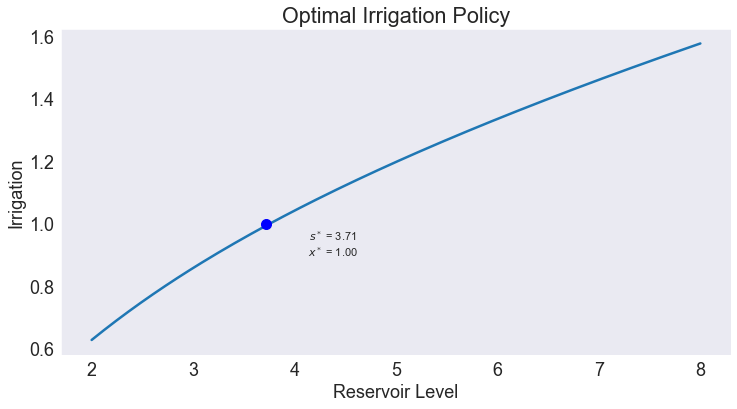

In [13]:
fig1 = demo.figure('Optimal Irrigation Policy', 'Reservoir Level', 'Irrigation')
plt.plot(S['Irrigation'])
demo.annotate(sstar, xstar,f'$s^*$ = {sstar:.2f}\n$x^*$ = {xstar:.2f}','bo', (10, -6),ms=10,fs=11)

### Value Function

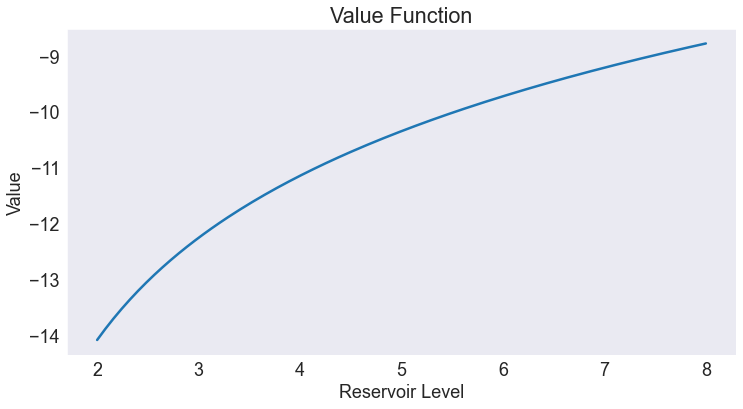

In [14]:
fig2 = demo.figure('Value Function', 'Reservoir Level', 'Value')
plt.plot(S['value'])

### Shadow Price Function

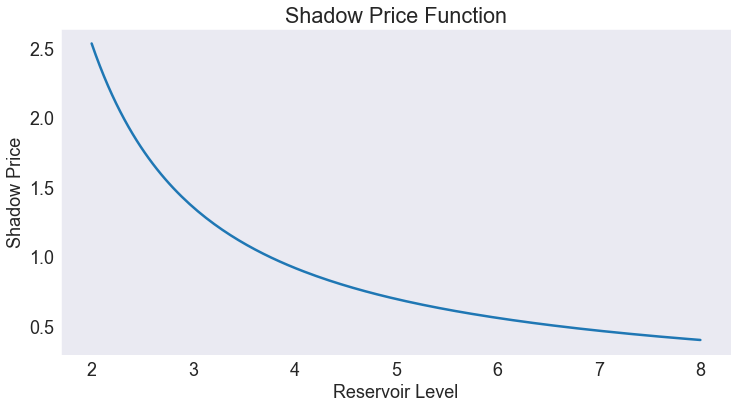

In [15]:
fig3 = demo.figure('Shadow Price Function', 'Reservoir Level', 'Shadow Price')
plt.plot(S['shadow price'])

### Chebychev Collocation Residual

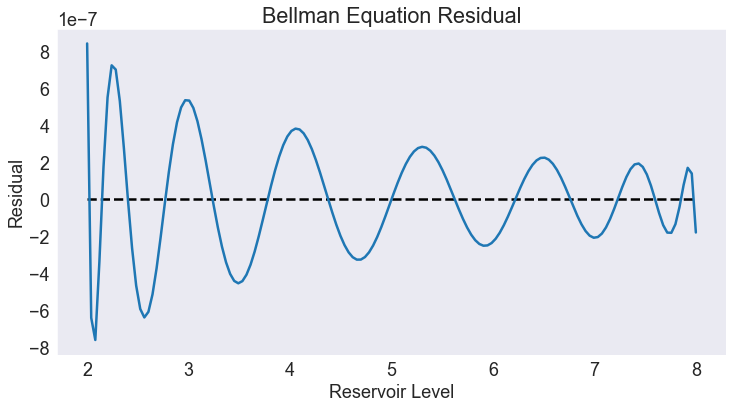

In [16]:
fig4 = demo.figure('Bellman Equation Residual', 'Reservoir Level', 'Residual')
plt.hlines(0,smin,smax,'k',linestyles='--')
plt.plot(S[['resid']])
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

## Simulating the model

We simulate 21 periods of the model starting from $s=s_{\min}$

In [17]:
T = 31
nrep = 100_000
data = water_model.simulate(T, np.tile(smin,nrep))

### Simulated State and Policy Paths

In [18]:
subdata = data[data['_rep'].isin(range(3))]
opts = dict(spec='r*', offset=(0, -15), fs=11, ha='right')

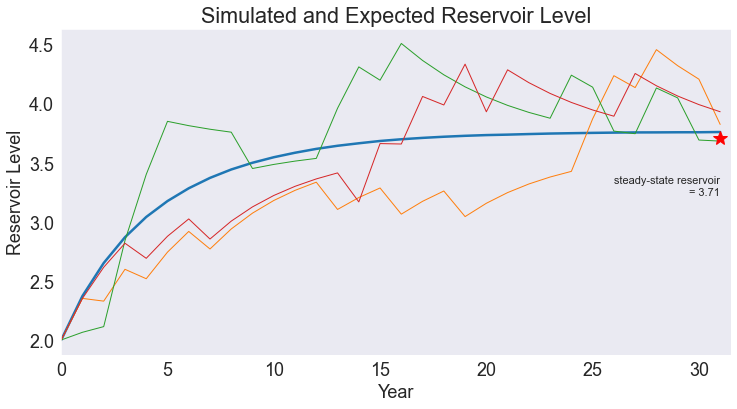

In [19]:
fig6 = demo.figure('Simulated and Expected Reservoir Level','Year', 'Reservoir Level',[0, T + 0.5])
plt.plot(data[['time','Reservoir']].groupby('time').mean())
plt.plot(subdata.pivot('time','_rep','Reservoir'),lw=1)
demo.annotate(T, sstar, f'steady-state reservoir\n = {sstar:.2f}', **opts)

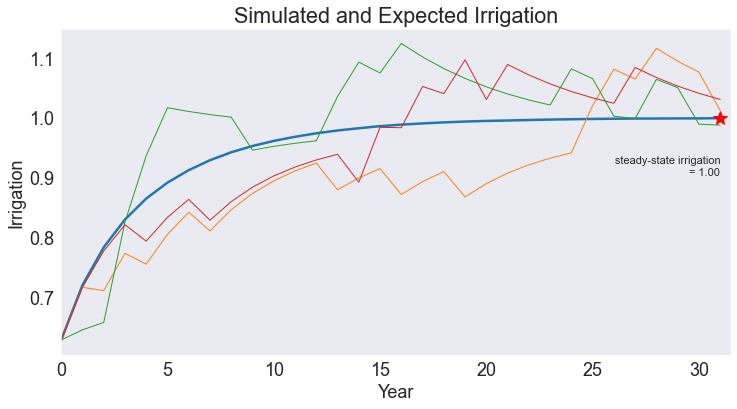

In [20]:
fig7 = demo.figure('Simulated and Expected Irrigation','Year', 'Irrigation',[0, T + 0.5])
plt.plot(data[['time','Irrigation']].groupby('time').mean())
plt.plot(subdata.pivot('time','_rep','Irrigation'),lw=1)
demo.annotate(T, xstar, f'steady-state irrigation\n = {xstar:.2f}', **opts)

### Ergodic Wealth Distribution

In [21]:
subdata = data[data['time']==T][['Reservoir','Irrigation']]
stats =pd.DataFrame({'Deterministic Steady-State': [sstar, xstar],
              'Ergodic Means': subdata.mean(),
              'Ergodic Standard Deviations': subdata.std()}).T
stats

,Reservoir,Irrigation
Deterministic Steady-State,3.714418,1.000000
Ergodic Means,3.761378,0.999158
Ergodic Standard Deviations,0.358699,0.062366


<AxesSubplot:title={'center':'Ergodic Reservoir and Irrigation Distribution'}, xlabel='Wealth', ylabel='Probability'>

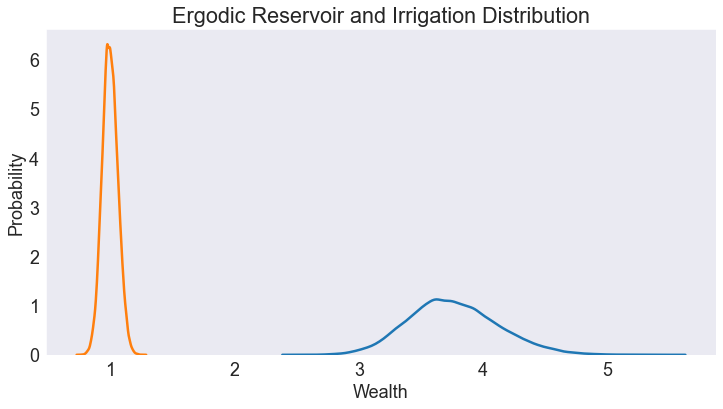

In [22]:
fig8 = demo.figure('Ergodic Reservoir and Irrigation Distribution','Wealth','Probability')
sns.kdeplot(subdata['Reservoir'])
sns.kdeplot(subdata['Irrigation'])

In [23]:
#demo.savefig([fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8])